In [1]:
%load_ext autoreload
%autoreload 2

In [85]:

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from PPO import PPOAGENT
from DQN import DQNAGENT
from sac import SACAgent
from td3 import TD3Agent

# Discrete Action Space

### Experiment: CartPole-v1

In [4]:
env = gym.make("CartPole-v1")
num_episodes = 500
training_time = 480  # 480 seconds = 8 minutes

In [5]:
import torch
import random
SEED = 42
# env.seed(SEED)
env.action_space.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [46]:
def plot_mean_std_curves(all_rewards_dict, title='Learning Curve', xlabel='Episode', ylabel='Reward'):
    plt.figure(figsize=(10, 6))
    for label, rewards in all_rewards_dict.items():
        mean_rewards = rewards.mean(axis=0)
        std_rewards = rewards.std(axis=0)
        episodes = np.arange(len(mean_rewards))
        plt.plot(episodes, mean_rewards, label=label)
        plt.fill_between(episodes, mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.2)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig("DQN, hard vs polyak")
    plt.show()

In [87]:
def run_ppo_variant(env, training_time=400, seeds=[42, 7, 99]):
    all_rewards = []

    for seed in seeds:
        env.reset(seed=seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

        agent = PPOAGENT(
             env, 
             t_timestep=3, 
             num_updates=4, 
             lr=0.005,
             hidden_size=128, 
             gamma=0.99, 
             clip=0.2
        )

        rewards = agent.learn(max_training_time=training_time)
        if len(rewards) > 400:
            rewards = rewards[:400]# sample_n_points(rewards, 500)
            
        all_rewards.append(rewards)

    return (all_rewards)


In [88]:
training_time = 10000
ppo_rewards_list = run_ppo_variant(env, training_time=training_time, seeds=[42, 7, 99])

  0%|                                                                          | 99/100000 [20:36<346:36:19, 12.49s/it]


In [92]:
len(ppo_rewards_list[0])

300

In [93]:
ppo_rewards_list_after_preprocess = []
for i in ppo_rewards_list:
    ppo_rewards_list_after_preprocess.append(i[:300])
    
ppo_rewards_list_after_preprocess = np.array(ppo_rewards_list_after_preprocess)

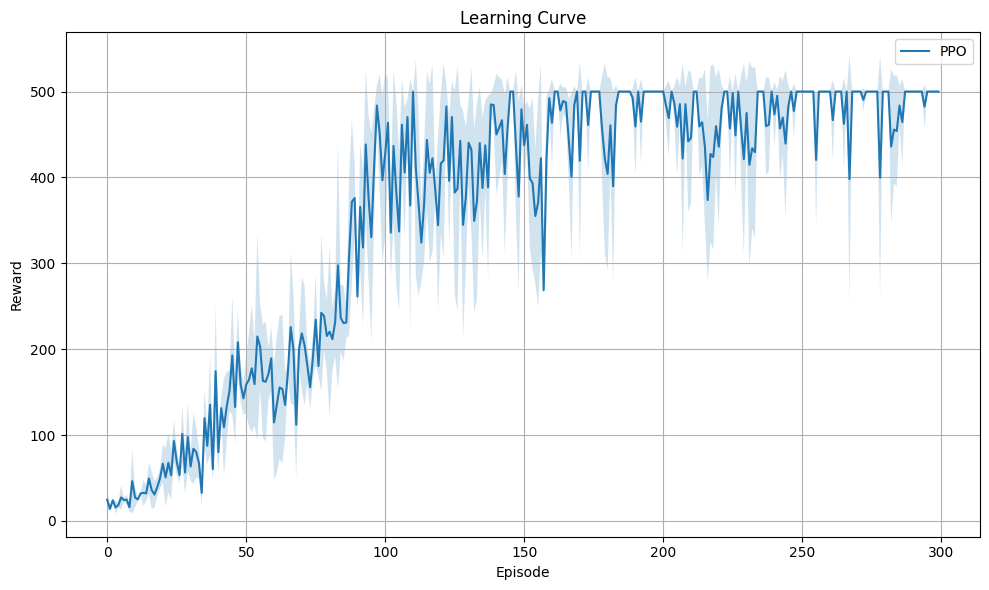

In [94]:
def plot_mean_std_curves(all_rewards_dict, title='Learning Curve', xlabel='Episode', ylabel='Reward'):
    plt.figure(figsize=(10, 6))
    for label, rewards in all_rewards_dict.items():
        mean_rewards = rewards.mean(axis=0)
        std_rewards = rewards.std(axis=0)
        episodes = np.arange(len(mean_rewards))
        plt.plot(episodes, mean_rewards, label=label)
        plt.fill_between(episodes, mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.2)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig("DQN, hard vs polyak")
    plt.show()

plot_mean_std_curves({
    "PPO": ppo_rewards_list_after_preprocess,
})

In [95]:
def run_dqn_variant(env, num_episodes=200, seeds=[42, 7, 99]):
    all_rewards = []

    for seed in seeds:
        env.reset(seed=seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

        dqn_polyak = DQNAGENT(
            env=env,
            lr=5e-4,           
            hidden_size=128,
            gamma=0.99,        
            tau=0.008,
            clip_value = 0.5,
            batch_size=256,    
            eps_start=0.95,
            eps_end=0.05,     
            eps_decay=600,     
            replay_size=100_000,
            learning_start = 100,
            train_freq = 2,
            target_update_freq = 0,
            is_first_update_target_hard = True
        )
        
        rewards = dqn_polyak.learn(num_episodes=num_episodes)
        all_rewards.append(rewards)

    return np.array(all_rewards) 

    

rewards_polyak_averaging = run_dqn_variant(env, num_episodes=400, seeds=[42, 7, 99])

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [10:17<00:00,  1.54s/it]


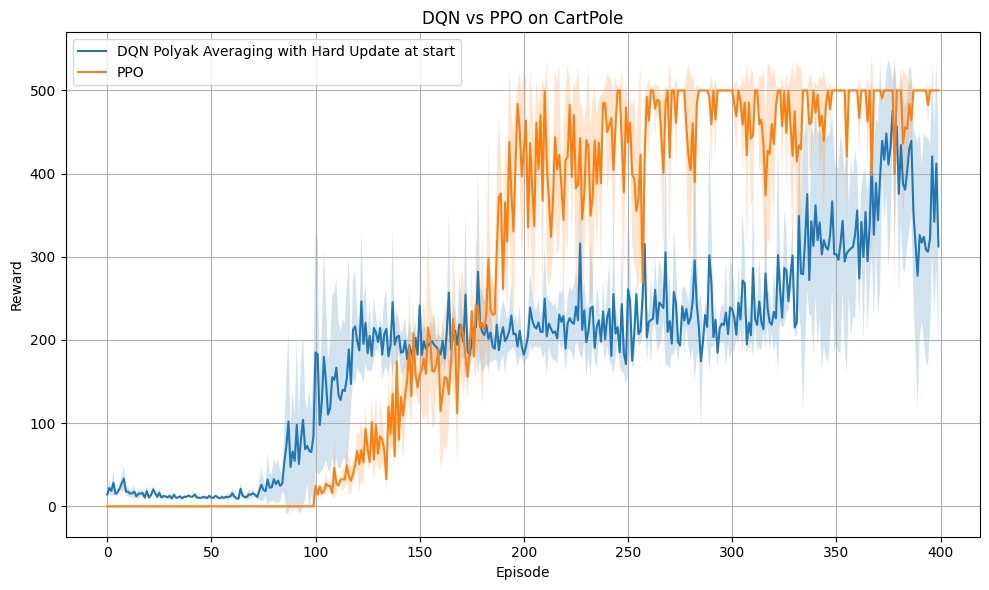

In [100]:
def plot_mean_std_curves(all_rewards_dict, title='DQN vs PPO on CartPole', xlabel='Episode', ylabel='Reward'):
    plt.figure(figsize=(10, 6))
    for label, rewards in all_rewards_dict.items():
        mean_rewards = rewards.mean(axis=0)
        std_rewards = rewards.std(axis=0)
        episodes = np.arange(len(mean_rewards))
        plt.plot(episodes, mean_rewards, label=label)
        plt.fill_between(episodes, mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.2)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("DQN vs PPO")
    plt.show()

plot_mean_std_curves({
    "DQN Polyak Averaging with Hard Update at start": rewards_polyak_averaging,
    "PPO": ppo_rewards_list
})

In [98]:
# Fill the first 100 steps, since DQN agent doesn't learn in these episodes and fills its buffer
ppo_rewards_list = np.zeros((3,400))
ppo_rewards_list[:,100:] = ppo_rewards_list_after_preprocess

In [ ]:
plot_mean_std_curves({
    "DQN Hard Update": rewards_polyak_averaging,
    "
})